<h1> Matlab code direct immigration </h3>

In [84]:
phase = np.zeros((Z, N, N))
amplitude = np.zeros((Z, N, N))

for i in tqdm(range(Z)):
    phase[i] = restoration.unwrap_phase(np.angle(retrieved_field[i]))
    amplitude[i] = np.abs(retrieved_field[i])

100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


In [49]:
viewer.add_image(phase)

<Image layer 'phase' at 0x18715962db0>

In [106]:
illumination_y_idx = np.zeros(Z)
illumination_x_idx = np.zeros(Z)
y_0 = 0
x_0 = 0

for i in range(Z):
    F_back = np.fft.fft2(retrieved_background[i])
    # find illumination center
    yx = get_maxindex(F_back)
    # normal illumination
    if i==0:
        y_0 = yx[0]
        x_0 = yx[1]
    
    # obliqueness
    illumination_y_idx[i] = y_0-yx[1]
    illumination_x_idx[i] = x_0-yx[0]

In [128]:
n_medium = 1.33
v0_nm = (1/lam) * n_medium

v0_x = dv * np.array(illumination_x_idx)
v0_y = dv * np.array(illumination_y_idx)
v0_z = np.real(np.sqrt(v0_nm**2 - v0_x**2 - v0_y**2))

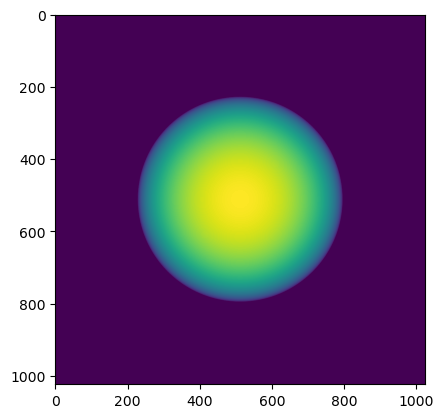

In [129]:
fourier_x = np.arange(-N//2, N//2) * dv
fourier_y = np.arange(-N//2, N//2) * dv
fourier_z = np.arange(-height//2, height//2) * dv

Fourier_X, Fourier_Y = np.meshgrid(fourier_x, fourier_y)
Fourier_Z = np.sqrt(Fourier_X**2 + Fourier_Y**2)

fourier_y = fourier_y[:, None]

v3 = v0_nm**2 - Fourier_Z**2
v3[v3<0] = 0
v3 = np.sqrt(v3)
plt.imshow(v3)

In [132]:
mask = Fourier_Z.copy()
mask[mask > 2*NA/lam] = 0
mask = mask.astype(bool)

rytov = np.zeros((N, N, height), dtype=np.complex128)
count = np.zeros((N, N, height))

In [133]:
filter = circular_filter((N, N), pixel_radius=int(v_optical/dv/2))

for i in tqdm(range(Z)):
    F_rytov = np.log(amplitude[i]) + 1j*phase[i]
    Us_rytov = np.fft.fftshift(np.fft.fft2(F_rytov)) * dx * dx
    Us_rytov = np.roll(Us_rytov, int(v0_y[i]/dv), axis=0)
    Us_rytov = np.roll(Us_rytov, int(v0_x[i]/dv), axis=1)
    Us_rytov = Us_rytov * filter
        
    size_check = np.zeros((N, N))
    vz = v3 + size_check
    vx = fourier_x + size_check
    vy = fourier_y + size_check
        
    Kx = vx - v0_x[i]
    Ky = vy - v0_y[i]
    Kz = vz - v0_z[i]
        
    Uprime = (vz/1j) * Us_rytov

    xind = np.where(
            ((vz > 0) * filter.astype(bool)) &
            (Kx > (dv * (-np.floor(N / 2)))) &
            (Ky > (dv * (-np.floor(N / 2)))) &
            (Kz > (dv_z * (-np.floor(height / 2)))) &
            (Kx < (dv * (np.floor(N / 2) - 1))) &
            (Ky < (dv * (np.floor(N / 2) - 1))) &
            (Kz < (dv_z * (np.floor(height / 2) - 1)))
        )
    xind = np.ravel_multi_index((xind[0], xind[1]), Uprime.shape)

    # 이 밑에가 ewald sphere 만드는부분
    Uprime = Uprime.flat[xind]
    Kx = Kx.flat[xind]
    Ky = Ky.flat[xind]
    Kz = Kz.flat[xind]

    Kx = np.round(Kx / dv + np.floor(N / 2) + 1).astype(int)
    Ky = np.round(Ky / dv + np.floor(N / 2) + 1).astype(int)
    Kz = np.round(Kz / dv_z + np.floor(height / 2) + 1).astype(int)

    Kzp = np.ravel_multi_index((Ky, Kx, Kz), count.shape)
        
    temp = rytov.flat[Kzp]
    rytov.flat[Kzp] = temp + Uprime
    count.flat[Kzp] += (Uprime != 0)

# Final computation and normalization
rytov[count > 0] = rytov[count > 0] / count[count > 0] / np.prod(np.array([dv, dv, dv_z]))

100%|██████████| 50/50 [00:06<00:00,  7.76it/s]


In [134]:
viewer.add_image(np.abs(rytov))

<Image layer 'Image [2]' at 0x1870ce97d40>

In [135]:
rytov_ifftn = np.fft.ifftn(rytov)
potential = rytov_ifftn * 4 * np.pi
k0 = 1/lam
k = 2 * np.pi * n_medium * k0
ri = n_medium * np.sqrt(1+potential/k**2)

# viewer.add_image(np.real(ri))

In [136]:
viewer.add_image(np.abs(rytov_ifftn))

<Image layer 'Image [3]' at 0x1870cfce0c0>

In [99]:
potential.max()

(2.2498334794762858e-21+1.3730350525015788e-22j)

In [96]:
viewer.add_image(np.real(ri))

<Image layer 'Image [2]' at 0x187084fe6f0>